## Examples

We are going to use two examples to illustrate how to use Kulprit for variable selection. 

* Body Fat: We will use the bodyfat data set {cite}`Penrose_1985`. The aim of the analysis is to predict an expensive and cumbersome water immersion measurement of body fat percentage (observed variable named `siri`) from a set of thirteen easier to measure characteristics, including `age`, `height`, `weight`, and `circumferences` of various body parts.

* Bikes: This dataset contains the number of bike rentals per hour (`count`) in a bike-sharing system, along with several features that can be used to predict the number of rentals, including `temperature`, `windsepeed`, `hour`, among others. We will use all the variables in the dataset.

In [ ]:
import arviz as az
import bambi as bmb
import kulprit as kpt
import numpy as np
import pandas as pd

az.style.use("arviz-white")
SEED = 2935
np.random.seed(SEED)

### Body Fat

The first thing we need to do is to load the data and define a model using Bambi. We are going to use a linear regression with Normal response. We need to set `idata_kwargs={'log_likelihood': True}` as we will later need to compute the [ELPD](https://arviz-devs.github.io/Exploratory-Analysis-of-Bayesian-Models/Chapters/Model_comparison.html#waic) of the reference models and submodels.

In [ ]:
body = pd.read_csv("body_fat.csv")
model = bmb.Model("siri ~" +  " + ".join([c for c in body.columns if c!="siri"]), data=body)
idata = model.fit(idata_kwargs={'log_likelihood': True}, random_seed=SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, age, weight, height, neck, chest, abdomen, hip, thigh, knee, ankle, biceps, forearm, wrist]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


To use Kulprit we first instantiate the `ProjectionPredictive` class and then call the `project` method, which is the one doing all the hard work.

In [ ]:
ppi = kpt.ProjectionPredictive(model, idata)
ppi.project()

Once this is finished we can print the `ppi` object. It will give us a list of the submodels in order of lowest ELPD to highest ELPD. The first model is always the intercept-only model. 

The [ELPD](https://arviz-devs.github.io/EABM/Chapters/Model_comparison.html#loo-and-cross-validation) is a measure of how well the model predicts the data, the higher the ELPD, the better the model. The ELPD is computed using the [Pareto smoothed importance sampling leave-one-out cross-validation](https://arxiv.org/abs/1507.04544) (PSIS-LOO-CV) method, which is an efficient way to approximate leave-one-out cross-validation {cite}`Vehtari_2017, Vehtari_2024`.

In [ ]:
ppi

  0 []
  1 ['abdomen']
  2 ['abdomen', 'weight']
  3 ['abdomen', 'weight', 'wrist']
  4 ['abdomen', 'weight', 'wrist', 'biceps']
  5 ['abdomen', 'weight', 'wrist', 'biceps', 'age']
  6 ['abdomen', 'weight', 'wrist', 'biceps', 'age', 'neck']
  7 ['abdomen', 'weight', 'wrist', 'biceps', 'age', 'neck', 'height']
  8 ['abdomen', 'weight', 'wrist', 'biceps', 'age', 'neck', 'height', 'thigh']
  9 ['abdomen', 'weight', 'wrist', 'biceps', 'age', 'neck', 'height', 'thigh', 'forearm']
 10 ['abdomen', 'weight', 'wrist', 'biceps', 'age', 'neck', 'height', 'thigh', 'forearm', 'ankle']
 11 ['abdomen', 'weight', 'wrist', 'biceps', 'age', 'neck', 'height', 'thigh', 'forearm', 'ankle', 'chest']
 12 ['abdomen', 'weight', 'wrist', 'biceps', 'age', 'neck', 'height', 'thigh', 'forearm', 'ankle', 'chest', 'knee']
 13 ['abdomen', 'weight', 'wrist', 'biceps', 'age', 'neck', 'height', 'thigh', 'forearm', 'ankle', 'chest', 'knee', 'hip']

We can inspect the `ppi` object manually, but a plot is usually a better idea. By default, the `compare` function plots all the models, including the intercept-only model. In the following block of code, we are asking to omit this model. 


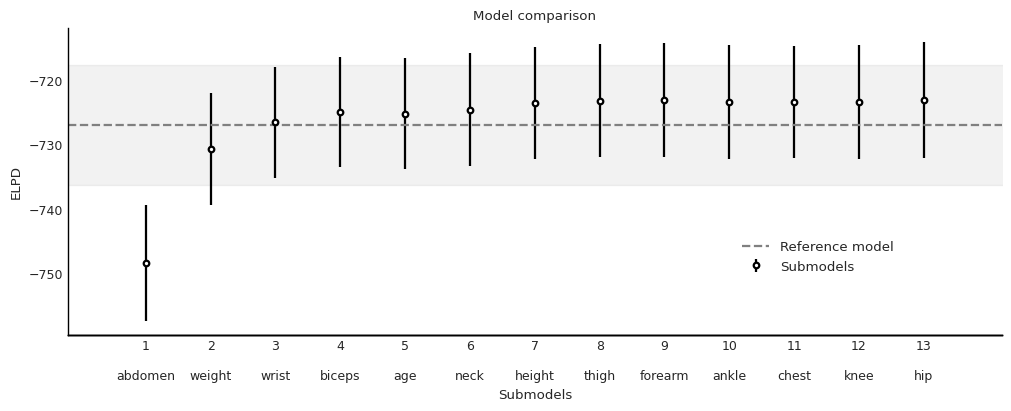

In [ ]:
ppi.compare(min_model_size=1);

From this plot we can see that the most relevant variable is `abdomen`, in the sense that if we were forced to pick a single variable, picking `abdomen` would be the one that would make the predictions most similar to the reference model. But the difference of ELPD between the submodel `abdomen` and the reference model is large, so we may want to include more variables. If we include `abdomen` and `weight` and `wrist` we should get a model that is statistically indistinguishable from the reference model (under the ELPD metric). The error bars of the ELPD give us an idea of the uncertainty of the ELPD estimate. This is telling us that if we were to repeat the experiment, it will be unlikely that `abdomen` is not included in the model first, but we may expect some switching between `weight` and `wrist` and even more for the other variables. 

Kulprit offers a method that can automatically perform the selection for us. There are two methods: `mean` and `se`. The first one selects the smallest submodel with an ELPD that is within 4 units of the reference model. The "se" methods selects the smallest submodel with an ELPD that is within one standard error of the reference model. Both criteria behave similarly. Usually, the `mean` criterion results in more stable selection, and
selects larger and better-performing submodels {cite}`Mclatchie_2024`.

In [ ]:
selected_submodel = ppi.select()
selected_submodel

['Intercept', 'abdomen', 'weight']

As usual statistical methods should help us make decisions, but they should not make decisions for us. When deciding which variables to include in the model we may prefer an order that is slightly different from the one provided by Kulprit, the decision could be based on extra information that is not included in the model. For example, it may be the case that after discussion with domain expert or coworkers we decided to avoid the use of a scale for future measurements and then we decide to include only `abdomen` and `wrist`. 

----

Usually for the purpose of variable selection we do not care about the projections themselves, as they are just an intermediate step to perform variable selecion. Nevertheless, we can explore the projected posterior. The `plot_densities` function allow us to plot the posterior densities of the reference model and the submodel. We can see that the posterior densities of the reference model and the largest submodel (i.e. the reference model projected onto itself) are very similar.

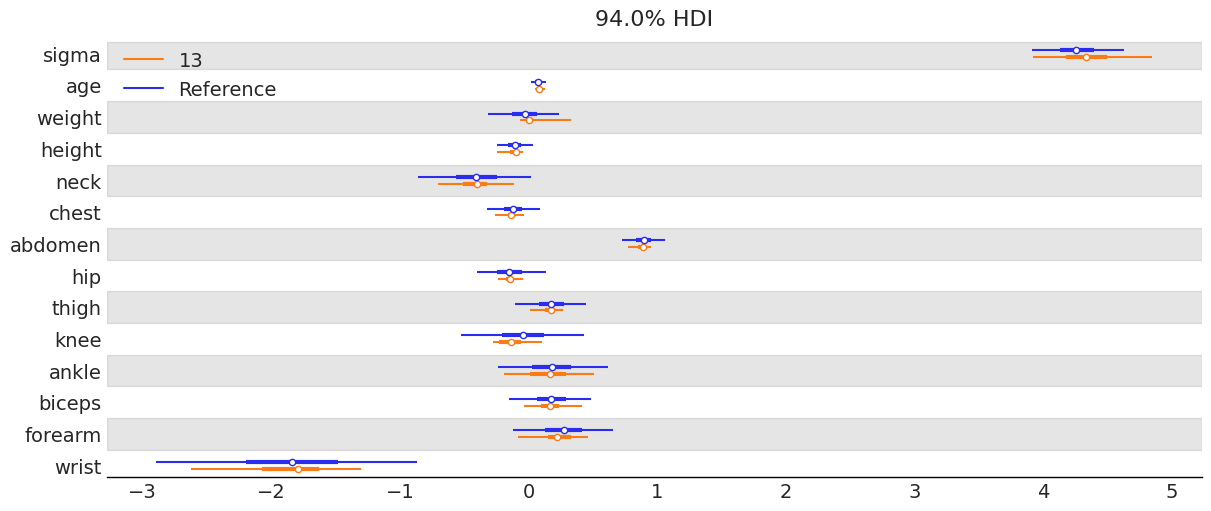

In [ ]:
ppi.plot_densities(var_names=["~Intercept", "~mu"],
                   submodels=[13],
                   kind="forest",
                   labels="size",
                   plot_kwargs={"figsize": (12, 5)},
                  );

Below we can see the projection for the submodel of size 3, `abdomen + weight + wrist`.

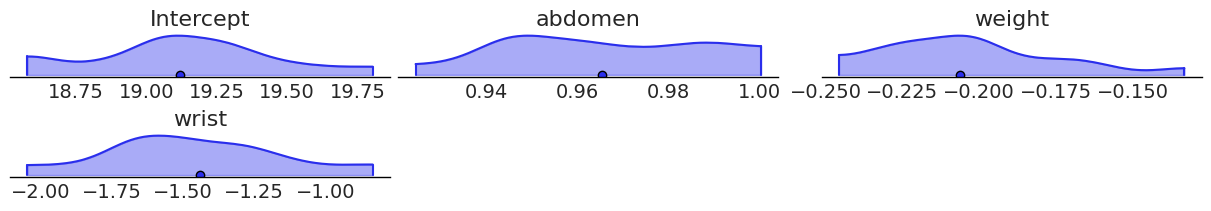

In [ ]:
ppi.plot_densities(
                   submodels=[3],
                   include_reference=False,
                   labels="size",
                   figsize=(12, 2),
                   plot_kwargs={"outline": True},
                  );

### Bikes

In [ ]:
bikes = pd.read_csv("bikes.csv")

One thing to note is that a linear model may have difficulties to handle the variable `hour` as it will miss the non-linearities in the data. For instance, we expect rentals to go up in the morning and in the evening, and to go down in the middle of the day and at night. To better handle this variable we could transform the variable `hour` into a set of dummy variables like 
 

```python
bikes = pd.read_csv("bikes.csv")
bikes["hour_sin"] = np.sin(bikes.hour * np.pi / 12)
bikes["hour_cos"] = np.cos(bikes.hour * np.pi / 12)
bikes.drop(columns="hour", inplace=True)
``` 

or we could use a more flexible model like splines (that is also a kind of data transformation). Let's try the latter.

In [ ]:
knots = range(1, 22, 5)
priors = {
    "alpha": bmb.Prior("Exponential", lam=1)
}

model = bmb.Model("count ~ bs(hour, knots=knots, intercept=True) + " + " + ".join(bikes.columns.drop(["count", "hour"])),
                  bikes,
                  family="negativebinomial",
                  priors=priors)

This time we are  going to pass Kulprit the Bambi model without fitting it. Kulprit will take care of fitting the model for us by calling PyMC under the hood.

/home/osvaldo/proyectos/00_BM/bambinos/kulprit/kulprit/projector.py:263: UserWarning: No InferenceData object provided. Building posterior from model.
  warnings.warn("No InferenceData object provided. Building posterior from model.")
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, bs(hour, knots=knots, intercept=True), season, month, holiday, weekday, workingday, weather, temperature, humidity, windspeed]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
Sampling: [count]


Output()

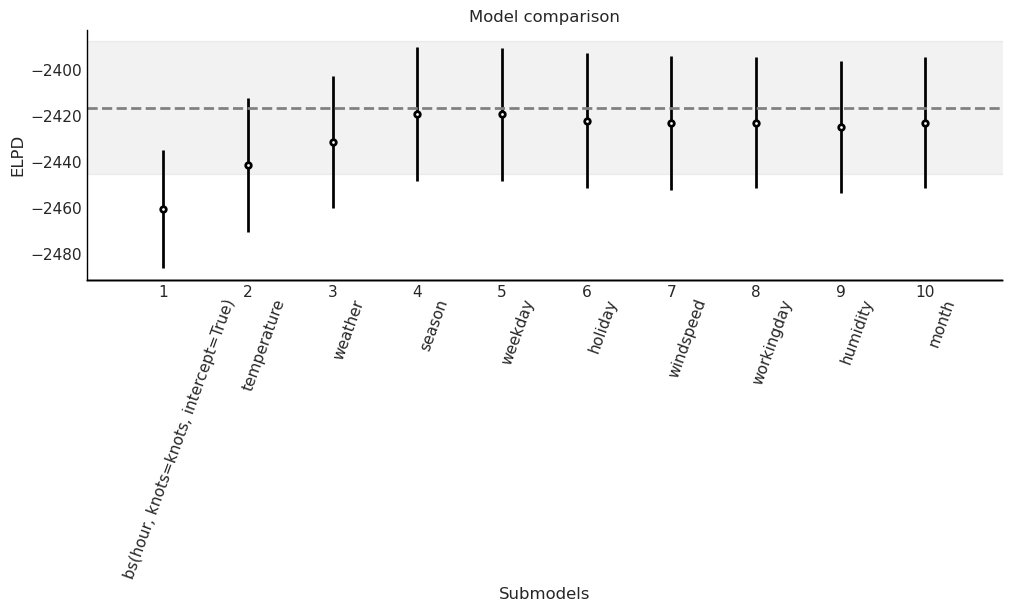

In [ ]:
ppi = kpt.ProjectionPredictive(model)
ppi.project()
ppi.compare(
            min_model_size=1,
            plot_kwargs={"xlabel_rotation": 70},
            legend=False,
            figsize=(10, 6),
            );

We can see that `hour` is the more important variable in the model, followed by `temperature` and `weather` and then the rest of the variables.

## Early stopping

If we have a lot of variables, we may want to stop the projection early. We can do this by setting the `early_stopping` argument (defaults to False). Currently, we have two options, they are `mean` and `se`, the same used by the `select` method.

/home/osvaldo/proyectos/00_BM/bambinos/kulprit/kulprit/projector.py:263: UserWarning: No InferenceData object provided. Building posterior from model.
  warnings.warn("No InferenceData object provided. Building posterior from model.")
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, bs(hour, knots=knots, intercept=True), season, month, holiday, weekday, workingday, weather, temperature, humidity, windspeed]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
Sampling: [count]


Output()

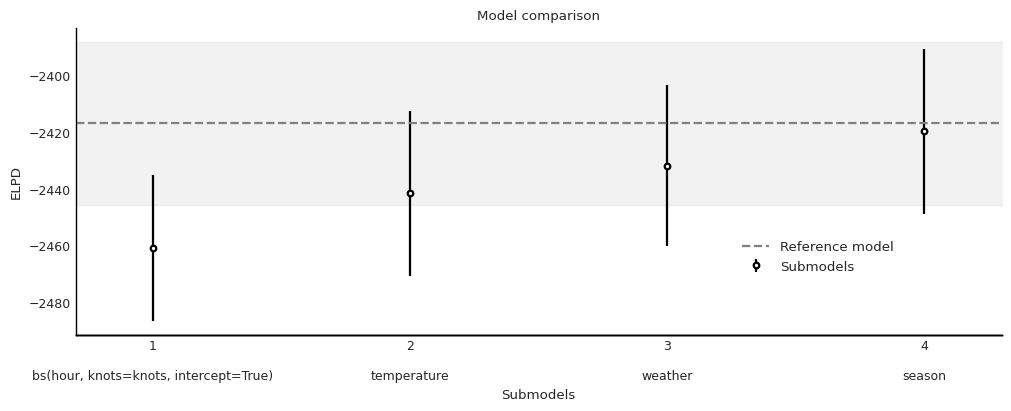

In [ ]:
ppi = kpt.ProjectionPredictive(model)
ppi.project(early_stop="mean")
ppi.compare(min_model_size=1);

## References
```{bibliography}
:style: unsrt
```